# Assignment 13: Jupyter Notebook Forecast
### The purpose of this notebook is to produce my week 13 forecast and showcase what I've learned since starting this course
### By Kevin Dyer

__________________________________________________________________________________

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import fiona
import shapely
from netCDF4 import Dataset
import matplotlib.dates as dates
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
import ulmo
import datetime
import os
import fiona
import logging
from shapely.geometry import Point
import contextily as ctx
import datetime
from matplotlib.dates import DateFormatter
from matplotlib.dates import DateFormatter
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm 
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

### First I import my packages. Besides the standard packages we've been loading in since the beginning, I've also added the packages ulmo and scipy which are necessary for the code I got from the Ipython notebook gallery for my analysis later.

In [76]:
flow_url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb" \
           "&site_no=09506000&referred_module=sw" \
           "&period=&begin_date=1989-01-01&end_date=2021-11-20"
flow_data = pd.read_table(flow_url, sep='\t', skiprows=30,
                          names=['agency_cd', 'site_no', 'datetime', 'flow',
                                 'code'], parse_dates=['datetime'])

### I now import the stream flow data using an api, directly from the USGS website. I format the data to remove the first 30 rows of from the data, which aren't pertinent information.

In [77]:
# Expand the dates to year month day, set index as base datetime
flow_data['year'] = pd.DatetimeIndex(flow_data['datetime']).year
flow_data['month'] = pd.DatetimeIndex(flow_data['datetime']).month
flow_data['day'] = pd.DatetimeIndex(flow_data['datetime']).day
flow_data['dayofweek'] = pd.DatetimeIndex(flow_data['datetime']).dayofweek
flow_data = flow_data.set_index('datetime')

month_median = np.zeros(31)
for d in range(31):
        daytemp = d+1
        tempdata = flow_data[(flow_data['year']) & (flow_data['month']) & (flow_data['day'] == daytemp)]
        month_median[d] = np.median(tempdata['flow'])
        print('Iteration', d, 'Day=', daytemp, 'Flow=', month_median[d])

Iteration 0 Day= 1 Flow= 154.5
Iteration 1 Day= 2 Flow= 154.5
Iteration 2 Day= 3 Flow= 156.5
Iteration 3 Day= 4 Flow= 154.5
Iteration 4 Day= 5 Flow= 153.0
Iteration 5 Day= 6 Flow= 156.5
Iteration 6 Day= 7 Flow= 160.0
Iteration 7 Day= 8 Flow= 160.0
Iteration 8 Day= 9 Flow= 159.5
Iteration 9 Day= 10 Flow= 154.0
Iteration 10 Day= 11 Flow= 159.5
Iteration 11 Day= 12 Flow= 166.5
Iteration 12 Day= 13 Flow= 166.5
Iteration 13 Day= 14 Flow= 167.5
Iteration 14 Day= 15 Flow= 167.5
Iteration 15 Day= 16 Flow= 169.5
Iteration 16 Day= 17 Flow= 170.5
Iteration 17 Day= 18 Flow= 174.5
Iteration 18 Day= 19 Flow= 166.5
Iteration 19 Day= 20 Flow= 169.0
Iteration 20 Day= 21 Flow= 167.0
Iteration 21 Day= 22 Flow= 161.0
Iteration 22 Day= 23 Flow= 163.0
Iteration 23 Day= 24 Flow= 169.0
Iteration 24 Day= 25 Flow= 163.0
Iteration 25 Day= 26 Flow= 159.0
Iteration 26 Day= 27 Flow= 166.0
Iteration 27 Day= 28 Flow= 174.0
Iteration 28 Day= 29 Flow= 180.0
Iteration 29 Day= 30 Flow= 178.0
Iteration 30 Day= 31 Flow= 17

### I now expand the dates to year, month, and day and set the index to base datetime.

### I also create an array for every day in a given month, from day 1 to 31, and set all those days to having a value of zero for now. Then I use the USGS flow data to find the median flow for every day of a given month from January 1st, 1989 to November 20th, 2021.

### The output is this median flow in cubic feet per seconds.

In [97]:
def flow_median(startyear, month, daysinmonth, flow_data):
        '''
        This function determines the median flow for any month, day, or year in the range of the data.

        Parameters:
        "month" represents the number of the month you want, int (October = 10)
        "startyear" the year range you want, int (year =< 2021)
        "daysinmonth" represents the amount of days in month, which for October, is 31.
        "flow_data" is my dataframe

        Output:
        This function returns a print statement that provides the median flow of that range
        '''
        flow_median = np.zeros(daysinmonth)
        for d in range(daysinmonth):
                daytemp = d+1
                tempdata = flow_data[(flow_data['year']>=startyear) & (flow_data['month'] == month) & (flow_data['day'] == daytemp)]
                flow_median[d] = np.median(tempdata['flow'])
        return flow_median

print('Iteration', d,'Day=', daytemp, 'Flow=', month_median[d])

Iteration 30 Day= 31 Flow= 173.5


### Now comes my function. What it does essentially is output the median flow for the date range you input. "Month" represents the number of the month you want to analyze (ie October = 10). "Startyear" represents the 4 digit year you want to start the anaysis from. "Daysinmonth" is the number of days in the month you're analyzing (ie 31 for October). And finally, "flow_data" which represents my dataframe.

In [96]:
startyear = 2016
month = 11
daysinmonth = 30

flow_subset = flow_median(startyear, month, daysinmonth, flow_data)

print(flow_subset)

[126.  127.  127.5 133.5 137.  138.5 138.5 140.  142.  141.  142.5 144.5
 144.5 145.  147.  148.  152.  149.5 155.  154.  160.  163.  163.  164.
 164.  162.  165.  167.  164.  169. ]


### This is where manipulation and analysis through my function can be done. By changing the values of the variables "startyear", "Month", and "Daysinmonth" one can analyze any month's median flowrate for any given day since 1989. And, through using the "Startyear" variable, one can even narrow down analyses to only include more recent years, accounting for the changing climate. 

In [98]:
print('My one week prediction for average flow is', np.mean(flow_subset[22:29]), \
        'ft^3/s, and my two week prediction is', np.median(flow_subset), \
        'ft^3/s. Both predictions are based off the median flow rates of Camp Verde from the Month of October since 2011. The 1 week prediction is the max of this subset of data due to the unusually high amount of rainfall recently, and the two week preidction is the median of this subset of data.')

My one week prediction for average flow is 164.14285714285714 ft^3/s, and my two week prediction is 147.5 ft^3/s. Both predictions are based off the median flow rates of Camp Verde from the Month of October since 2011. The 1 week prediction is the max of this subset of data due to the unusually high amount of rainfall recently, and the two week preidction is the median of this subset of data.


### I then take the mean of the days representing the week I'm analyzing (from the 22nd till the 28th for Week 13), and the median for the entire month to get my 2-week forecast. All of this is then written into a print statement that clearly states my methodology and reasoning.

### I've changed my forecasting function slightly over time. Recently I've made my 1-week flow take the mean of the historic flow data from the flow_subset between the days I'm currently predicting for.

In [81]:
file = os.path.join('..','..', 'data',"gagesII_9322_point_shapefile",
                    'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)


### I now start to make my map. I first import my map data from the stream gauge shapefiles from the USGS website.

In [82]:
gages.STATE.unique()
gages_AZ=gages[gages['STATE']=='AZ']

# Reading in a geodataframe
file = os.path.join('..','..', 'data', 'NHDPLUS_H_1506_HU4_GDB.gdb')
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6")

### I then further define my gages object to only include data from Arizona. Next, I import my watershed boundary shapefle I downloaded from NOAA's website. This is the HUC 6 boundary

In [83]:
# Added points
# Stream gauge in Camp Verde:  34.44833333, -111.7891667 and UA: 32.22877495, -110.97688412
point_list = np.array([[-111.7891667, 34.44833333],
                        [-110.97688412, 32.22877495]])
#make these into spatial features
point_geom = [Point(xy) for xy in point_list]
point_geom

#map a dataframe of these points
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'],
                            crs=HUC6.crs)

### I now add a couple points to my map. One representing the the position of the Camp Verde stream gauge we've been forecasting for, and the other representing the University of Arizona's campus. These points are then made into spatial features and then a dataframe is mapped of these points.

In [84]:
# CRS = Coordinate Reference System
HUC6.crs
gages.crs

# Projecting the point
points_project = point_df.to_crs(gages_AZ.crs)

HUC6_project = HUC6.to_crs(gages_AZ.crs)

### Here I define the coordinate reference system to be used for this map, and project my data points and watershed onto it. This is necessary so that my points are properly geopositioned where they're supposed to be, and not far off somewhere else.

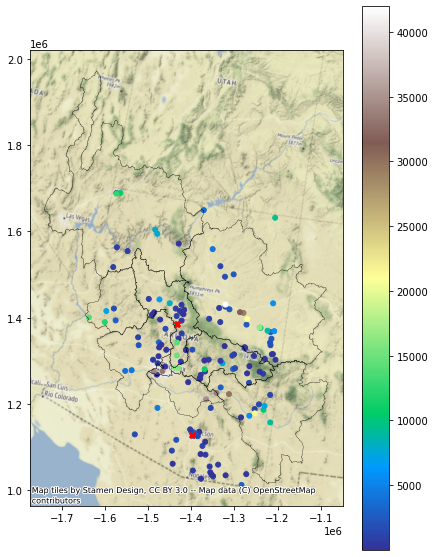

In [85]:
fig, ax = plt.subplots(figsize=(7, 10))
gages_AZ.plot(column='DRAIN_SQKM', categorical=False,
              legend=True, markersize=25, cmap='terrain',
              ax=ax)
points_project.plot(ax=ax, color='red', marker='X')
HUC6_project.boundary.plot(ax=ax, color=None,
                           edgecolor='black', linewidth=.3)
ctx.add_basemap(ax, crs=gages_AZ.crs, source = ctx.providers.Stamen.Terrain)
fig.savefig("AZ_Watershed")

### Finally, I have my map. Zoomed into the state of Arizona, You can just make out the HUC6 boundary I used. I set the line thickness to be just thick enough to be seen easily, but not overpowering other map elements. The red 'X's on the map represent the Camp Verde stream gauge and the University of Arizona repectively. The stream gages, seen here sorted by their drainage per square kilometer using the "terrain" color map, are seen scattered throughout the general region around our stream gauge in Camp Verde. The entire map is overlayed over the "stamen.terrain" basemap. I chose this particular base map because I believed it had the greatest readability whilst not sacrificing the fidelity of the points and watershed boundary lines overlayed on the map.

### I chose to make this map to showcase the influences the topography and watershed can have on the flow of the Camp Verde stream gauge.

In [110]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Now I begin using the script I recieved from the python gallery to make some climatography based graphs

### Here is the link I used: https://nbviewer.org/github/koldunovn/earthpy.org/blob/master/content/ulmo.ipynb

In [113]:
st = ulmo.ncdc.ghcn_daily.get_stations(country='US', as_dataframe=True)

In [114]:
st.head()

,country,network,network_id,latitude,longitude,elevation,state,name,gsn_flag,hcn_flag,wm_oid,id
id,,,,,,,,,,,,
US009052008,US,0,09052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA),NaN,NaN,NaN,US009052008
US10RMHS145,US,1,0RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,NaN,NaN,NaN,US10RMHS145
US10adam001,US,1,0adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S,NaN,NaN,NaN,US10adam001
US10adam002,US,1,0adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,NaN,NaN,NaN,US10adam002
US10adam003,US,1,0adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW,NaN,NaN,NaN,US10adam003


In [118]:
st[st.name.str.contains('AZ')]

,country,network,network_id,latitude,longitude,elevation,state,name,gsn_flag,hcn_flag,wm_oid,id
id,,,,,,,,,,,,
US1ALDK0019,US,1,ALDK0019,34.2108,-86.0761,329.5,AL,BOAZ 4.6 E,NaN,NaN,NaN,US1ALDK0019
US1ALMD0006,US,1,ALMD0006,34.9352,-86.5835,246.9,AL,HAZEL GREEN 1.2 NW,NaN,NaN,NaN,US1ALMD0006
US1ALMD0083,US,1,ALMD0083,34.9869,-86.6437,270.4,AL,HAZEL GREEN 6.2 NW,NaN,NaN,NaN,US1ALMD0083
US1ALMD0094,US,1,ALMD0094,34.9164,-86.6320,249.3,AL,HAZEL GREEN 3.7 W,NaN,NaN,NaN,US1ALMD0094
US1ARLG0001,US,1,ARLG0001,35.1918,-93.8307,185.6,AR,MAGAZINE 3.0 NNW,NaN,NaN,NaN,US1ARLG0001
...,...,...,...,...,...,...,...,...,...,...,...,...
USR0000TBRA,US,R,0000TBRA,29.1417,-95.2917,3.0,TX,BRAZORIA NWR TEXAS,NaN,NaN,NaN,USR0000TBRA
USW00012976,US,W,00012976,29.1097,-95.4619,7.6,TX,ANGLETON BRAZORIA AP,NaN,NaN,NaN,USW00012976
USW00013780,US,W,00013780,37.5333,-77.4167,49.4,VA,RICHMOND CHIMBORAZO PK,NaN,NaN,NaN,USW00013780


### I begin by importing the gauge data from the United States using the ULMO package, and then sort by AZ to see if I could find anything in Arizona. I'm out of luck, but do find a gauge in New Mexico and use that.

In [119]:
data = ulmo.ncdc.ghcn_daily.get_data('USW00053017', as_dataframe=True)

## This function returns dictionary with names of the variables as keys and pandas data frames with measurements as values

In [121]:
tm = data['TMAX'].copy()
tm.head()

,value,mflag,qflag,sflag
month_period,,,,
2010-09-01,255.0,NaN,NaN,R
2010-09-02,279.0,NaN,NaN,R
2010-09-03,267.0,NaN,NaN,R
2010-09-04,280.0,NaN,NaN,R
2010-09-05,270.0,NaN,NaN,R


### This is the max temperature at the gauge. These values are then divided by ten to get degrees C

<AxesSubplot:xlabel='month_period'>

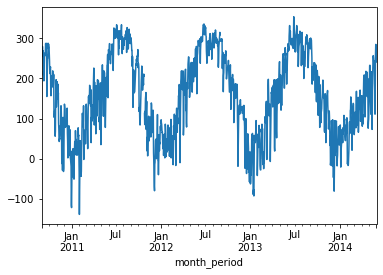

In [127]:
tm['value']['2010':'2015'].plot()

### I get this plot returned, showing the max temperature recorded at the gauge in AZTEC 43 E in New Mexico, daily, since 2010

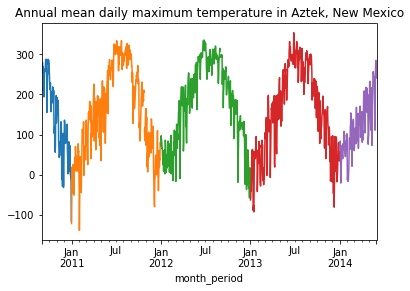

In [134]:
tm.value = tm.value.astype('float')
tm['2010':'2015'].value.resample('A').plot()
title('Annual mean daily maximum temperature in Aztek, New Mexico')
fig.savefig("NM_Temperature")

### And finally, I'm able to further modify my graph to look like this, with years color sorted, and a title added. 